In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pyhf

jax.config.update("jax_enable_x64", True)

from model import simplemodel2
from relax import infer

In [2]:
N = 27000
SCALE = 100

N = 2700000
SCALE = 10000


def generate_data():
    b1 = np.random.multivariate_normal([+1.0, +0.0], np.eye(2), size=N // 4)
    b2 = np.random.multivariate_normal([+0.0, +0.0], np.eye(2), size=N // 4)
    b3 = np.random.multivariate_normal([-1.0, -0.0], np.eye(2), size=N // 4)

    s1 = np.random.multivariate_normal([3.0, 0.0], np.eye(2), size=N // 16)

    return s1, b1, b2, b3


anchr = jnp.array([0.0, 0.0])
data = generate_data()

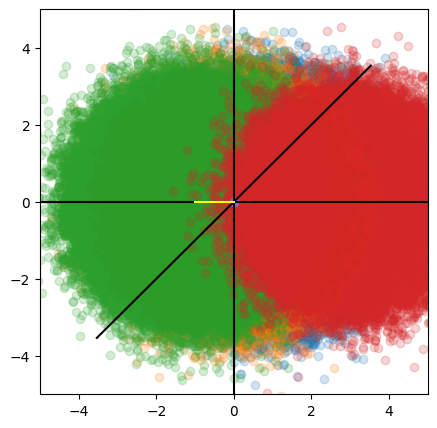

In [4]:
def plot_data(anchr, data):
    s1, b1, b2, b3 = data
    plt.scatter(b1[:, 0], b1[:, 1], alpha=0.2)
    plt.scatter(b2[:, 0], b2[:, 1], alpha=0.2)
    plt.scatter(b3[:, 0], b3[:, 1], alpha=0.2)
    plt.scatter(s1[:, 0], s1[:, 1], alpha=0.2)

    plt.scatter(anchr[0], anchr[1])
    for angle in [0.0, jnp.pi / 4, jnp.pi / 2]:

        direc = jnp.array([jnp.cos(angle), jnp.sin(angle)])
        normal = jnp.array([jnp.cos(angle + jnp.pi / 2), jnp.sin(angle + jnp.pi / 2)])

        lp = jax.vmap(lambda alpha: anchr + alpha * direc)(jnp.linspace(-5, 5))
        plt.plot(lp[:, 0], lp[:, 1], c="k")

    t = np.stack([anchr, anchr + normal])
    plt.plot(t[:, 0], t[:, 1], c="yellow")
    plt.gcf().set_size_inches(5, 5)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)


plot_data(anchr, data)

In [5]:
def run_thing(angle, anchr, data, plot=False, syst=True, ax=None, print_yields=False):
    s1, b1, b2, b3 = data

    direc = jnp.array([jnp.cos(angle), jnp.sin(angle)])
    normal = jnp.array([jnp.cos(angle + jnp.pi / 2), jnp.sin(angle + jnp.pi / 2)])

    bins = jnp.linspace(-100, 100, 3)
    hb1 = np.histogram(jnp.matmul((b1 - anchr), normal), bins=bins)
    hb2 = np.histogram(jnp.matmul((b2 - anchr), normal), bins=bins)
    hb3 = np.histogram(jnp.matmul((b3 - anchr), normal), bins=bins)

    hs1, _ = np.histogram(jnp.matmul((s1 - anchr), normal), bins=bins)

    nb1 = (hb1 / SCALE).tolist()
    nb2 = (hb2 / SCALE).tolist()
    nb3 = (hb3 / SCALE).tolist()

    ns1 = (hs1 / SCALE).tolist()

    if syst:
        nb1, nb2, nb3 = nb1, nb2, nb3
    else:
        nb1, nb2, nb3 = nb2, nb2, nb2

    if print_yields:
        print(bins)
        print(ns1, nb2, nb2, nb2)
        print(sum(ns1), sum(nb2), sum(nb2), sum(nb2))

    if plot:
        ax = ax or plt.gca()
        ax.stairs(nb1, bins)
        ax.stairs(nb2, bins)
        ax.stairs(nb3, bins)
        ax.stairs(ns1, bins)

        # print(np.array([nb1,nb2,nb3]))
        # print(ns1)
    m = simplemodel2(ns1, nb1, nb2, nb3)

    exp_data = m.expected_data([0.0, 0.0])
    cls_val = pyhf.infer.hypotest(1.0, exp_data, m)
    return cls_val


run_thing(angle=jnp.pi, anchr=anchr, data=data)

array(0.05689634)

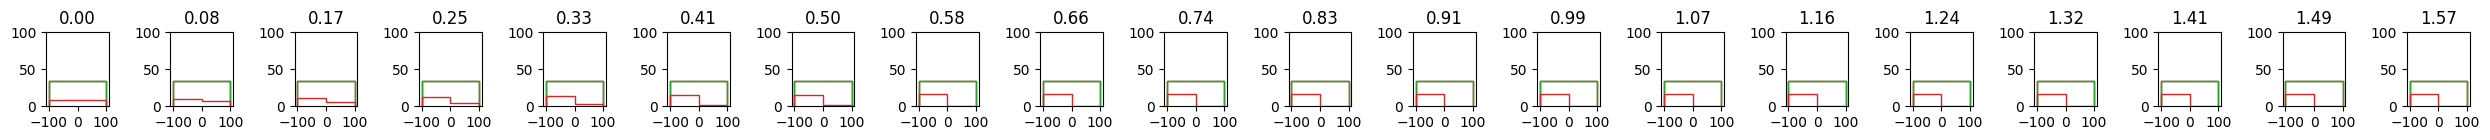

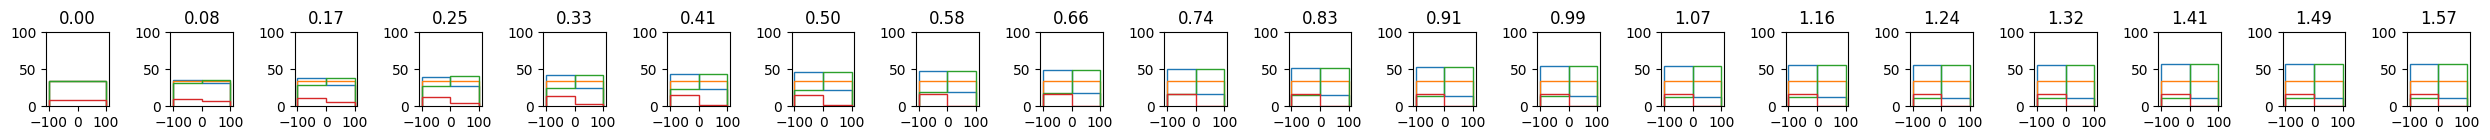

In [6]:
def plot_configs():
    f, axarr = plt.subplots(1, 20)
    f.set_size_inches(25, 1.5)
    for a, ax in zip(np.linspace(0, jnp.pi / 2.0, 20), axarr.ravel()):
        run_thing(angle=a, anchr=anchr, data=data, syst=False, plot=True, ax=ax)
        ax.set_ylim(0, 100)
        ax.set_title(f"{a:.2f}")
    f.set_tight_layout(True)

    f, axarr = plt.subplots(1, 20)
    f.set_size_inches(25, 1.5)
    for a, ax in zip(np.linspace(0, jnp.pi / 2.0, 20), axarr.ravel()):
        run_thing(angle=a, anchr=anchr, data=data, syst=True, plot=True, ax=ax)
        ax.set_ylim(0, 100)
        ax.set_title(f"{a:.2f}")
    f.set_tight_layout(True)


plot_configs()

In [7]:
def run_with_and_without_systs(anchr, data, angles):
    r1 = jnp.array(
        [run_thing(angle=a, anchr=anchr, data=data, syst=True) for a in angles]
    )
    r2 = jnp.array(
        [run_thing(angle=a, anchr=anchr, data=data, syst=False) for a in angles]
    )
    return r1, r2


angles = jnp.linspace(0, jnp.pi / 2.0, 51)
r1, r2 = run_with_and_without_systs(anchr, data, angles)

0.34557519189487723 0.04708610814673648
1.5707963267948966 0.011663473547555639


(0.0, 1.5707963267948966)

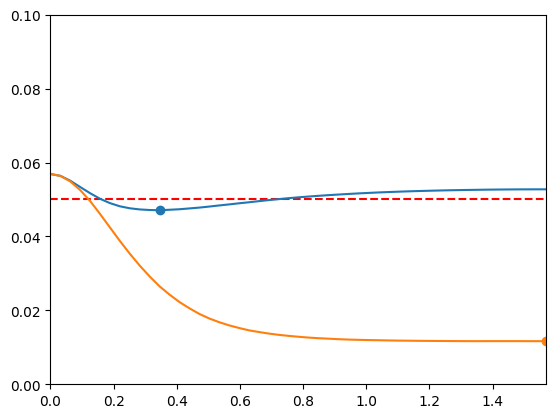

In [8]:
plt.plot(angles, r1)
plt.scatter(angles[np.argmin(r1)], r1[np.argmin(r1)])
print(angles[np.argmin(r1)], r1[np.argmin(r1)])

plt.plot(angles, r2)
plt.scatter(angles[np.argmin(r2)], r2[np.argmin(r2)])
print(angles[np.argmin(r2)], r2[np.argmin(r2)])

plt.hlines(0.05, 0, jnp.pi / 2.0, colors="r", linestyles="dashed")
plt.ylim(0.0, 0.1)
plt.xlim(0, jnp.pi / 2.0)